## validation 

In [1]:


from stock_reader import reader
import os
import pandas as pd
import numpy as np
import talib

Enter Code or Symbol :  005930
Enter start date(YYYY-MM--DD) :  20070101
Enter end date(YYYY-MM--DD) :  20200427



     Symbol  Name          Sector
951  005930  삼성전자  통신 및 방송 장비 제조업

             open   high    low  close    volume    change
Date                                                      
2007-01-02  12400  12540  12320  12500    355265  0.019576
2007-01-03  12540  12560  12220  12220    394730 -0.022400
2007-01-04  12220  12240  12060  12140    381464 -0.006547
2007-01-05  12160  12180  11900  11900    586649 -0.019769
2007-01-08  11840  11880  11580  11640    682494 -0.021849
...           ...    ...    ...    ...       ...       ...
2020-04-21  49400  49700  48700  49250  27407543 -0.016966
2020-04-22  48700  50000  48350  49850  18613864  0.012183
2020-04-23  50200  50300  49500  49850  18754442  0.000000
2020-04-24  49650  49750  49000  49350  15618347 -0.010030
2020-04-27  49350  50000  49100  49850  14049471  0.010132

[3290 rows x 6 columns]


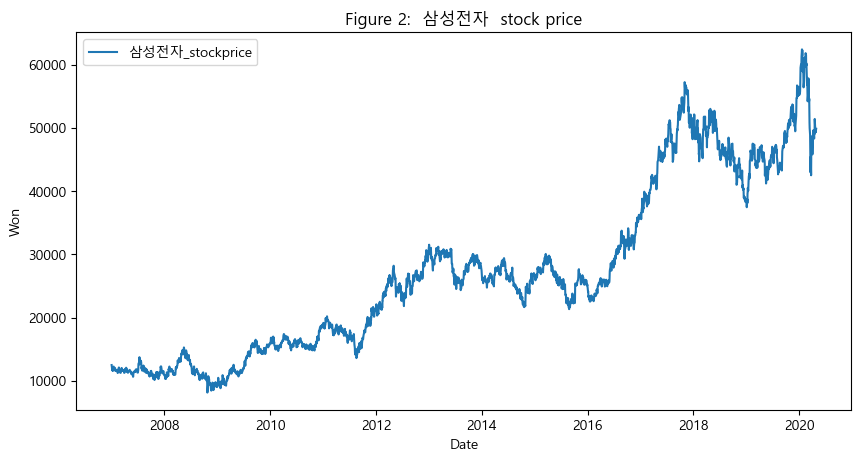


There are 3290 number of days in the dataset.



In [2]:
df = reader()

In [3]:
df=df[::-1]

In [4]:
df=df.reset_index(drop=True)
df.rename(columns={"final":"close","vol":"volume"}, inplace = True)
df

,open,high,low,close,volume,change
0,49350,50000,49100,49850,14049471,0.010132
1,49650,49750,49000,49350,15618347,-0.010030
2,50200,50300,49500,49850,18754442,0.000000
3,48700,50000,48350,49850,18613864,0.012183
4,49400,49700,48700,49250,27407543,-0.016966
...,...,...,...,...,...,...
3285,11840,11880,11580,11640,682494,-0.021849
3286,12160,12180,11900,11900,586649,-0.019769
3287,12220,12240,12060,12140,381464,-0.006547
3288,12540,12560,12220,12220,394730,-0.022400


In [5]:
def Indicators(df): # date close open high low volume 컬럼순 
                    # 결측치 33줄 생김 0~32 까지
    df['sma5'] = talib.SMA(np.asarray(df['close']), 5)
    df['sma20'] = talib.SMA(np.asarray(df['close']), 20)
    #df['sma120'] = talib.SMA(np.asarray(df['close']), 120)
    df['ema12'] = talib.SMA(np.asarray(df['close']), 12)
    df['ema26'] = talib.SMA(np.asarray(df['close']), 26)
    upper, middle, lower = talib.BBANDS(np.asarray(df['close']), timeperiod=20, nbdevup=2, nbdevdn=2, matype=0)
    df['dn'] = lower
    df['mavg'] = middle
    df['up'] = upper
    df['pctB'] = (df.close - df.dn)/(df.up - df.dn)
    rsi14 = talib.RSI(np.asarray(df['close']), 14)
    df['rsi14'] = rsi14
    macd, macdsignal, macdhist = talib.MACD(np.asarray(df['close']), 12, 26, 9)  
    df['macd'] = macd
    df['macdsignal'] = macdsignal
    df['obv']=talib.OBV(df['close'], df['volume'])
    df['ad'] = talib.AD(df['high'], df['low'], df['close'], df['volume'])
    df['ADOSC'] = talib.ADOSC(df['high'], df['low'], df['close'], df['volume'], fastperiod=3, slowperiod=10)
    return df

In [6]:
df[['close','open','high','low','volume']]=df[['close','open','high','low','volume']].astype(float)
df=Indicators(df)

In [8]:
df.loc[32:33]

,open,high,low,close,volume,change,sma5,sma20,ema12,ema26,dn,mavg,up,pctB,rsi14,macd,macdsignal,obv,ad,ADOSC
32,52500.0,52500.0,52000.0,52500.0,6225196.0,-0.001901,53200.0,51517.5,52308.333333,52228.846154,49009.258584,51517.5,54025.741416,0.695854,47.424372,NaN,NaN,-49603023.0,1.268683e+07,4.446463e+06
33,51800.0,52600.0,51600.0,52600.0,6576148.0,0.019380,53020.0,51572.5,52416.666667,52086.538462,49020.348946,51572.5,54124.651054,0.701301,48.115877,-643.024415,-1318.98596,-43026875.0,1.926298e+07,8.068825e+06


In [7]:
import os
import pandas as pd
import numpy as np
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler,RobustScaler
import matplotlib.pyplot as plt
import math
from sklearn.metrics import mean_squared_error

look_back = 50
def create_dataset(dataset, look_back=50):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i + look_back)].values.tolist()
        dataX.append(a)
        dataY.append(dataset.iloc[i + look_back]['close'])
    return np.array(dataX), np.array(dataY)

df=df.iloc[33:]
df=df.fillna(0)
#df=df.drop(columns=['date'])
nptf=np.array(df)

Using TensorFlow backend.


In [ ]:
np.random.seed(7)

In [8]:

# normalization
Xscaler = RobustScaler()
Yscaler = RobustScaler()
Xscaler.fit(nptf)
Yscaler.fit(nptf[:,3].reshape(-1,1))

nptf = pd.DataFrame(Xscaler.transform(nptf),columns=df.columns)


In [12]:

# split train, test
train_size = int(len(nptf) * 0.95)
test_size = len(nptf) - train_size
train, test = nptf[0:train_size], nptf[train_size:len(nptf)]
print(len(train), len(test))
 
# create dataset for learning
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)
 
# reshape input to be [samples, time steps, features]
trainX = np.reshape(trainX, (trainX.shape[0],  trainX.shape[1],nptf.shape[1]))
testX = np.reshape(testX, (testX.shape[0],  testX.shape[1],nptf.shape[1]))
 
# simple lstm network learning
model = Sequential()
model.add(LSTM(128, input_shape=(look_back, nptf.shape[1])))
model.add(Dense(32, activation='relu'))
model.add(Dense(16, activation='relu'))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam',metrics = ['mae'])
model.summary()
 

3094 163
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_2 (LSTM)                (None, 128)               76288     
_________________________________________________________________
dense_4 (Dense)              (None, 32)                4128      
_________________________________________________________________
dense_5 (Dense)              (None, 16)                528       
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 17        
Total params: 80,961
Trainable params: 80,961
Non-trainable params: 0
_________________________________________________________________


In [13]:
from keras.callbacks import EarlyStopping
early_stop = EarlyStopping(monitor='loss', patience=1, verbose=1) # early_stop 
model.fit(trainX, trainY, epochs=40, batch_size=512, verbose=1,callbacks=[early_stop])

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Epoch 1/40
3043/3043 [==============================] - 2s 718us/step - loss: 0.3690 - mean_absolute_error: 0.4152
Epoch 2/40
3043/3043 [==============================] - 0s 116us/step - loss: 0.0773 - mean_absolute_error: 0.1875
Epoch 3/40
3043/3043 [==============================] - 0s 114us/step - loss: 0.0304 - mean_absolute_error: 0.1186
Epoch 4/40
3043/3043 [==============================] - 0s 114us/step - loss: 0.0195 - mean_absolute_error: 0.0866
Epoch 5/40
3043/3043 [==============================] - 0s 115us/step - loss: 0.0093 - mean_absolute_error: 0.0607
Epoch 6/40
3043/3043 [==============================] - 0s 117us/step - loss: 0.0080 - mean_absolute_error: 0.0556
Epoch 7/40
3043/3043 [==============================] - 0s 115us/step - loss: 0.0053 - mean_absolute_error: 0.0468
Epoch 8/40
3043/3043 [==============================] - 0s 114us/step - loss: 0.0039 - mean_absolut

In [14]:

# make prediction
testPredict = model.predict(testX)
testPredict = Yscaler.inverse_transform(testPredict)
testY = Yscaler.inverse_transform(testY.reshape(-1,1))
testScore = math.sqrt(mean_squared_error(testY, testPredict))
print('Train Score: %.2f RMSE' % testScore)

Train Score: 309.04 RMSE


In [15]:
score = model.evaluate(testX,testY , batch_size=512)

print("MSE : ",score)

112/112 [==============================] - 0s 1ms/step
MSE :  [134610608.0, 11598.103515625]


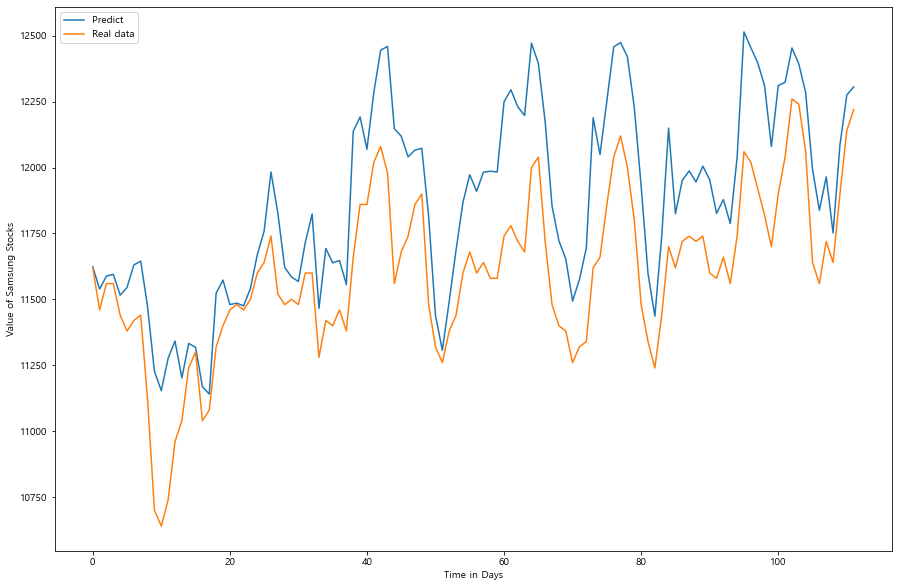

In [20]:

# plot
plt.rcParams["figure.figsize"] = (15,10)
plt.plot(testPredict, label = 'Predict')
plt.plot(testY, label = 'Real data')
plt.xlabel('Time in Days')
plt.ylabel('Value of Samsung Stocks')
plt.legend(loc = 'upper left')
plt.show()

In [21]:
from sklearn.externals import joblib 
# 객체를 pickled binary file 형태로 저장한다 
file_name = 'Xscale.pkl' 
joblib.dump(Xscaler, file_name) 
file_name = 'Yscale.pkl' 
joblib.dump(Yscaler, file_name)

['Yscale.pkl']

In [22]:
from keras.models import load_model
model.save('LSTM.h5')

In [23]:
xs=joblib.load('Xscale.pkl')
ys=joblib.load('Yscale.pkl')
LSTM = load_model('LSTM.h5')

In [24]:
# make prediction
tp = LSTM.predict(testX)
tp = ys.inverse_transform(tp)

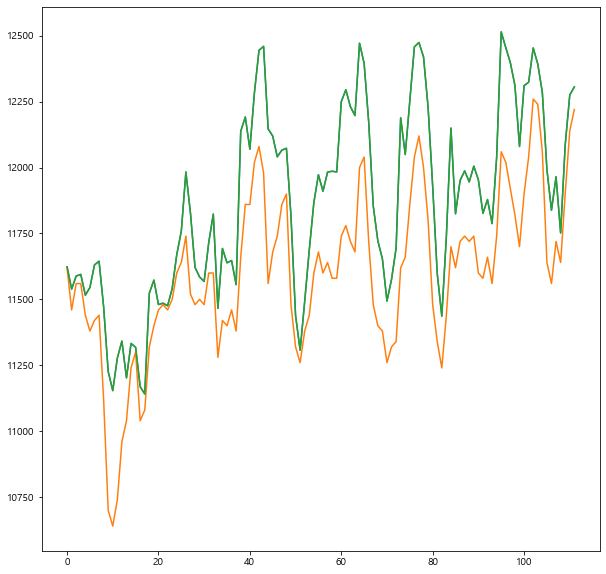

In [26]:

# plot
plt.rcParams["figure.figsize"] = (10,10)
plt.plot(testPredict)
plt.plot(testY)
plt.plot(tp)
plt.show()

In [28]:
def create_dataset(dataset):
    dataX, dataY = [], []
    for i in range(len(dataset)-1):
        a = dataset.iloc[i].values.tolist()
        dataX.append(a)
        dataY.append(dataset.iloc[i+1]['close'])
    return np.array(dataX), np.array(dataY)

In [27]:
nptf

,open,high,low,close,volume,change,sma5,sma20,ema12,ema26,dn,mavg,up,pctB,rsi14,macd,macdsignal,obv,ad,ADOSC
0,1.636259,1.675086,1.656577,1.676640,92.976024,0.343819,1.496979,1.289876,1.312879,1.267056,1.115370,1.289876,1.409491,1.307427,1.101721,0.918190,-1.228387,54.004062,-16.260926,-81.906081
1,1.688222,1.680827,1.650757,1.653625,87.576570,-1.896482,1.558564,1.305867,1.339994,1.278332,1.090993,1.305867,1.459599,1.071832,1.015806,1.475571,-0.675146,51.162475,-16.922915,-72.349855
2,1.792148,1.807118,1.802095,1.785961,53.791507,-1.047815,1.634673,1.333488,1.386652,1.296114,1.059143,1.333488,1.537370,1.184937,1.272841,2.193306,-0.084229,52.919990,-18.069342,-67.988014
3,1.855658,1.853042,1.831199,1.860759,62.519080,0.324651,1.716012,1.365471,1.461403,1.314655,1.030863,1.365471,1.620063,1.140945,1.402434,2.899530,0.534451,54.957548,-15.768976,-47.735666
4,1.693995,1.830080,1.708964,1.837745,71.493656,1.681859,1.777597,1.399198,1.520031,1.332654,1.028927,1.399198,1.683398,0.961226,1.309088,3.369449,1.126507,52.632019,-12.482265,-17.554942
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3252,-0.786374,-0.794489,-0.795111,-0.795167,1.015905,-1.017878,-0.800604,-0.801303,-0.803596,-0.778202,-0.805474,-0.801303,-0.770741,-0.291610,-0.134429,0.138536,0.224772,0.253512,0.918678,-0.170328
3253,-0.767898,-0.777268,-0.776484,-0.780207,0.735422,-0.921005,-0.802463,-0.800837,-0.803694,-0.777204,-0.804945,-0.800837,-0.770343,0.262462,0.287503,0.147974,0.213024,0.308599,0.828845,-0.822541
3254,-0.764434,-0.773823,-0.767171,-0.766398,0.134964,-0.304992,-0.796653,-0.799267,-0.802130,-0.776250,-0.803656,-0.799267,-0.768575,0.722436,0.614592,0.185871,0.211458,0.344419,0.822355,-1.050070
3255,-0.745958,-0.755454,-0.757858,-0.761795,0.173786,-1.043560,-0.788984,-0.797407,-0.799590,-0.774949,-0.802130,-0.797407,-0.766478,0.814765,0.715159,0.224999,0.218290,0.381484,0.761910,-1.371392


In [29]:

nptf = pd.DataFrame(nptf,columns=df.columns)

In [30]:

# split train, test
train_size = int(len(nptf) * 0.95)
test_size = len(nptf) - train_size
train, test = nptf[0:train_size], nptf[train_size:len(nptf)]
print(len(train), len(test))
 
# create dataset for learning
trainX, trainY = create_dataset(train)
testX, testY = create_dataset(test)

3094 163


In [31]:
import lightgbm as lgb
train_ds = lgb.Dataset(trainX, label = trainY) 
test_ds = lgb.Dataset(testX, label = testY) 

In [32]:
params = {'learning_rate': 0.01, 
          'max_depth': 16, 
          'boosting': 'gbdt', 
          'objective': 'regression', 
          'metric': 'mse', 
          'is_training_metric': True, 
          'num_leaves': 144, 
          'feature_fraction': 0.9, 
          'bagging_fraction': 0.7, 
          'bagging_freq': 5, 
          'seed':2018}

In [33]:
params = {'learning_rate': 0.01,
          'boosting': 'gbdt', 
          'objective': 'regression', 
          'metric': 'mse'
          }

In [34]:
model = lgb.train(params, train_ds, 1000, test_ds, verbose_eval=100, early_stopping_rounds=100)

Training until validation scores don't improve for 100 rounds
[100]	valid_0's l2: 0.110331
[200]	valid_0's l2: 0.01464
[300]	valid_0's l2: 0.00197018
[400]	valid_0's l2: 0.000287825
[500]	valid_0's l2: 6.79136e-05
[600]	valid_0's l2: 4.28511e-05
[700]	valid_0's l2: 3.81958e-05
[800]	valid_0's l2: 3.56688e-05
[900]	valid_0's l2: 3.40896e-05
[1000]	valid_0's l2: 3.3296e-05
Did not meet early stopping. Best iteration is:
[993]	valid_0's l2: 3.3235e-05


In [35]:
file_name = 'lgb2.pkl' 
joblib.dump(model, file_name) 

['lgb2.pkl']

In [36]:
predict_test = model.predict(testX)

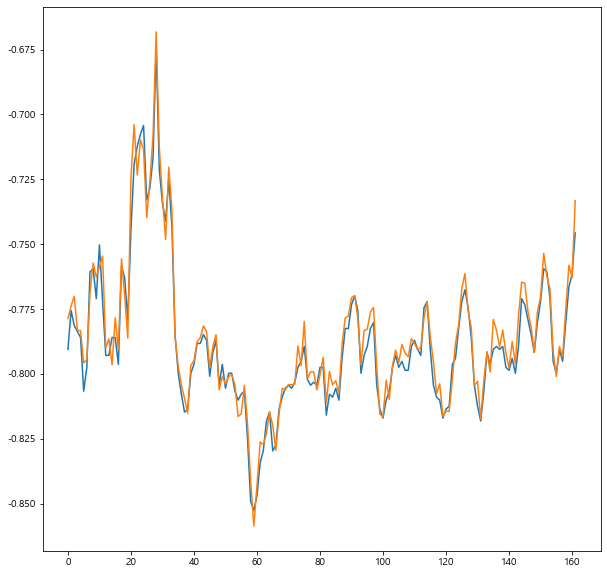

In [37]:
# plot
plt.rcParams["figure.figsize"] = (10,10)
plt.plot(testY)
plt.plot(predict_test)
plt.show()

In [38]:
import xgboost
model = xgboost.XGBRegressor(learning_rate=0.1,
                             max_depth=5,
                             n_estimators=100) 
model.fit(trainX,trainY)

[10:59:18] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=5, min_child_weight=1, missing=None, n_estimators=100,
             n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
             silent=None, subsample=1, verbosity=1)

In [39]:
file_name = 'xgb.pkl' 
joblib.dump(model, file_name) 

['xgb.pkl']

In [40]:
predict_test = model.predict(testX)

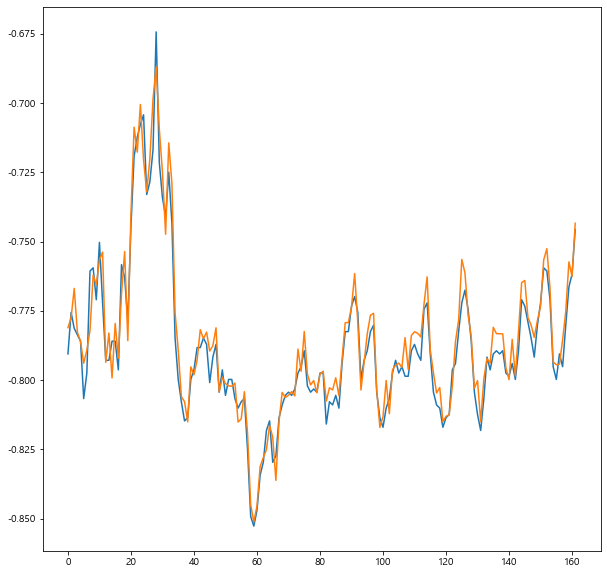

In [41]:
# plot
plt.rcParams["figure.figsize"] = (10,10)
plt.plot(testY)
#plt.plot(testY)
plt.plot(predict_test)
plt.show()